In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from utils import load_problem_data
from evaluation import get_actual_demand, change_elasticity_format, change_selling_prices_format


In [2]:
DEMAND, DATACENTERS, SERVERS, SELLING_PRICES, PRICE_ELASTICITY = load_problem_data('../data')

In [3]:
np.random.seed(2381)
ACTUAL_DEMAND = get_actual_demand(DEMAND)

In [4]:
ACTUAL_DEMAND

latency_sensitivity,time_step,server_generation,high,low,medium
0,1,CPU.S1,6144,12075,8039
1,1,GPU.S1,22,4,15
2,2,CPU.S1,12818,21297,16556
3,2,GPU.S1,49,11,32
4,3,CPU.S1,17707,29525,24347
...,...,...,...,...,...
667,167,GPU.S3,3741,5385,911
668,168,CPU.S3,122497,401896,79215
669,168,CPU.S4,652327,1649200,521952
670,168,GPU.S2,326,679,344


In [5]:
def calculate_moving_average(actual_demand: pd.DataFrame = ACTUAL_DEMAND, window_size: int = 7) -> pd.DataFrame:
    moving_average_df = actual_demand.copy()
    
    server_generations = actual_demand['server_generation'].unique()
    
    for generation in server_generations:
        df_gen = moving_average_df[moving_average_df['server_generation'] == generation]
        
        for column in ['high', 'medium', 'low']:
            moving_avg = df_gen[column].rolling(window=window_size, center=True, min_periods=1).mean().round().astype(int)
            moving_average_df.loc[df_gen.index, column] = moving_avg
    
    return moving_average_df

In [6]:
def ma_demand_plot(demand: pd.DataFrame, window_size: int = 7):
    server_generations = demand['server_generation'].unique()
    
    # Calculate moving average
    moving_average_df = calculate_moving_average(window_size=12)
    
    # Create subplots vertically
    _, axes = plt.subplots(len(server_generations), 1, figsize=(12, 8 * len(server_generations)))
    plt.subplots_adjust(left=0.2)  # Make room for check buttons
    
    colors = {'high': 'red', 'medium': 'green', 'low': 'blue'}
    
    # Plot for each server generation
    for i, generation in enumerate(server_generations):
        df_gen = demand[demand['server_generation'] == generation]
        df_ma_gen = moving_average_df[moving_average_df['server_generation'] == generation]
        
        ax = axes[i] if len(server_generations) > 1 else axes
        
        for column in ['high', 'medium', 'low']:
            color = colors[column]
            
            # Plot original data
            ax.plot(df_gen['time_step'], df_gen[column], label=f'{column.capitalize()}',
                    color=color, marker='o', alpha=0.5)
            
            # Plot moving average
            ax.plot(df_ma_gen['time_step'], df_ma_gen[column], label=f'{column.capitalize()} MA',
                    color=f'dark{color}', linestyle='-', linewidth=2)
        
        ax.set_title(f'Demand Trajectory for {generation}')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Demand')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

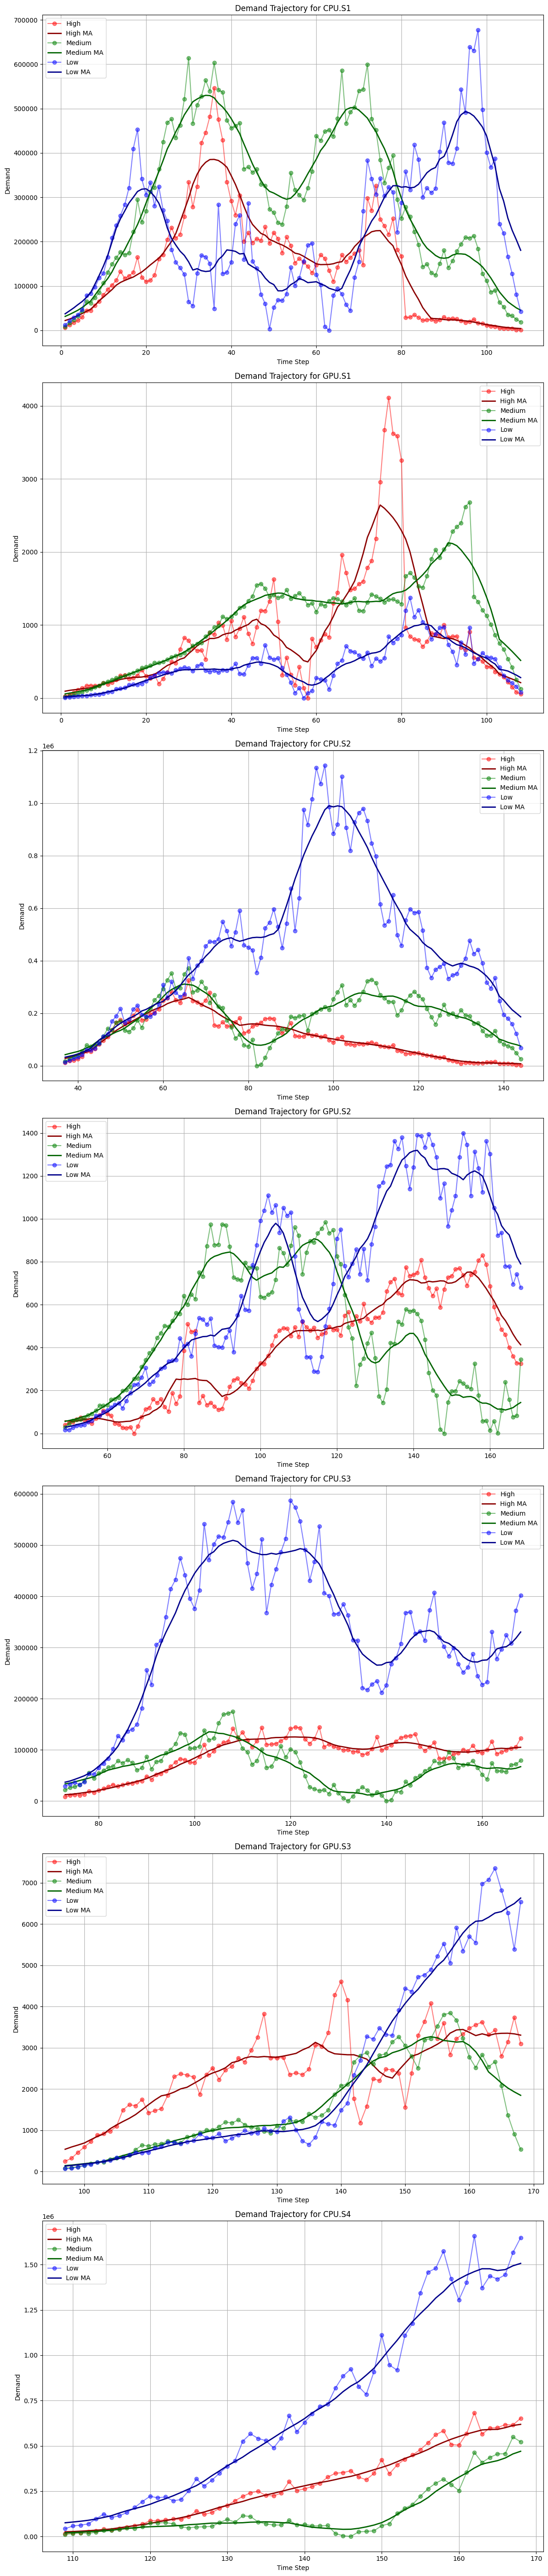

In [7]:
ma_demand_plot(ACTUAL_DEMAND, 12)

In [8]:
selling_prices = change_selling_prices_format(SELLING_PRICES)
elasticity = change_elasticity_format(PRICE_ELASTICITY)
moving_average = calculate_moving_average(ACTUAL_DEMAND, 12)

In [9]:
def get_new_demand_for_new_price(d0, p0, p1, e):
    # CALCULATE THE NEW DEMAND ACCORDING TO THE NEW PRICE
    delta_p = (p1 - p0) / p0
    print(delta_p)
    delta_p_e = delta_p * e
    print(delta_p_e)
    d1 = d0 * (1 + delta_p_e)
    print(d1)
    if d1 < 0:
        return 0
    return int(d1)


In [10]:
def calculate_new_price(d0, d1, p0, e):
    """
    Calculate the new price based on:
    d0: old demand
    d1: new demand (moving average)
    p0: old price
    e: price elasticity of demand
    """
    if d0 == 0:
        return p0  # Avoid division by zero
    
    delta_d = (d1 - d0) / d0
    print(delta_d)
    delta_p = delta_d / e
    print(delta_p)
    p1 = p0 * (1 + delta_p)
    print(p1)
    return max(p1, 0)  # Ensure price is non-negative


In [11]:
def adjust_prices_and_demand(actual_demand: pd.DataFrame, moving_average: pd.DataFrame, 
                             selling_prices: pd.DataFrame, price_elasticity: pd.DataFrame) -> tuple:
    new_prices_rows = []
    new_demand = actual_demand.copy()

    grouped = actual_demand.groupby(['time_step', 'server_generation'])
    ma_grouped = moving_average.groupby(['time_step', 'server_generation'])

    for (time_step, server_gen), group in grouped:
        ma_group = ma_grouped.get_group((time_step, server_gen))
        
        new_prices_row = {'time_step': time_step, 'server_generation': server_gen}
        new_demand_row = {}

        for level in ['high', 'medium', 'low']:
            actual = group[level].values[0]
            target = ma_group[level].values[0]
            current_price = selling_prices.loc[server_gen, level]
            elasticity = price_elasticity.loc[server_gen, level]

            # Calculate new price
            new_price = calculate_new_price(actual, target, current_price, elasticity)
            new_prices_row[level] = new_price

            # Calculate new demand
            new_demand_value = get_new_demand_for_new_price(actual, current_price, new_price, elasticity)
            new_demand_row[level] = new_demand_value

        new_prices_rows.append(new_prices_row)

        # Update new_demand DataFrame
        new_demand.loc[(new_demand['time_step'] == time_step) & 
                       (new_demand['server_generation'] == server_gen), 
                       ['high', 'medium', 'low']] = list(new_demand_row.values())

    # Create new_prices DataFrame from the list of rows
    new_prices = pd.DataFrame(new_prices_rows)

    return new_prices, new_demand

In [12]:
new_prices, new_demand = adjust_prices_and_demand(ACTUAL_DEMAND, moving_average, selling_prices, elasticity)

2.6300455729166665
-1.3618100941283222
-9.045252353208056
-1.0
1.93128659
18009.824808960002
2.9272297549446447
-2.332133472958748
-19.98200209438122
-1.0
1.25517248
18129.331566719997
2.0968115942028986
-2.028204084287028
-10.28204084287028
-1.0
1.033826729
24558.457752675004
3.272727272727273
-1.2200157560466611
-412.52954258748963
-1.0
2.682528694
81.015631268
2.8
-2.369782503816217
-2301.2346064112444
-1.0
1.18154303
32.723145450000004
4.0
-3.1149177316274472
-3172.376597441171
-1.0
1.284143064
9.136572256000001
0.9880636604774535
-0.5116090307847337
12.209774230381656
-0.5116090307847337
0.9880636604774534
25483.0
1.1637472819521624
-0.9271612471555801
1.092581292666298
-0.9271612471555801
1.1637472819521624
35823.0
1.0618396957317933
-1.0270963846706591
-0.2709638467065911
-1.0
1.033826729
43314.40784751301
1.1428571428571428
-0.4260372481432785
1076.180159731353
-0.4260372481432785
1.1428571428571428
105.0
1.09375
-0.9256962905532099
124.83023187060736
-0.9256962905532099
1.0937

In [13]:
new_demand

latency_sensitivity,time_step,server_generation,high,low,medium
0,1,CPU.S1,18009,24558,18129
1,1,GPU.S1,81,9,32
2,2,CPU.S1,25483,43314,35823
3,2,GPU.S1,105,23,67
4,3,CPU.S1,29327,50572,40576
...,...,...,...,...,...
667,167,GPU.S3,3339,6498,1932
668,168,CPU.S3,105068,330240,67192
669,168,CPU.S4,618543,1506856,469952
670,168,GPU.S2,413,789,143


In [14]:
moving_average

latency_sensitivity,time_step,server_generation,high,low,medium
0,1,CPU.S1,22303,37394,31571
1,1,GPU.S1,94,20,57
2,2,CPU.S1,25483,43911,35823
3,2,GPU.S1,105,23,67
4,3,CPU.S1,29327,50572,40576
...,...,...,...,...,...
667,167,GPU.S3,3339,6498,1932
668,168,CPU.S3,105068,330241,67192
669,168,CPU.S4,618543,1506856,469953
670,168,GPU.S2,413,790,144


In [22]:
n_p = calculate_new_price(19, 248, 1800, -1.993403965)
n_d = get_new_demand_for_new_price(19, 1800, n_p, -1.993403965)

12.052631578947368
-6.046256449052146
-9083.261608293864
-1.0
1.993403965
56.87467533499999


In [23]:
print(n_p)
print(n_d)

0
56


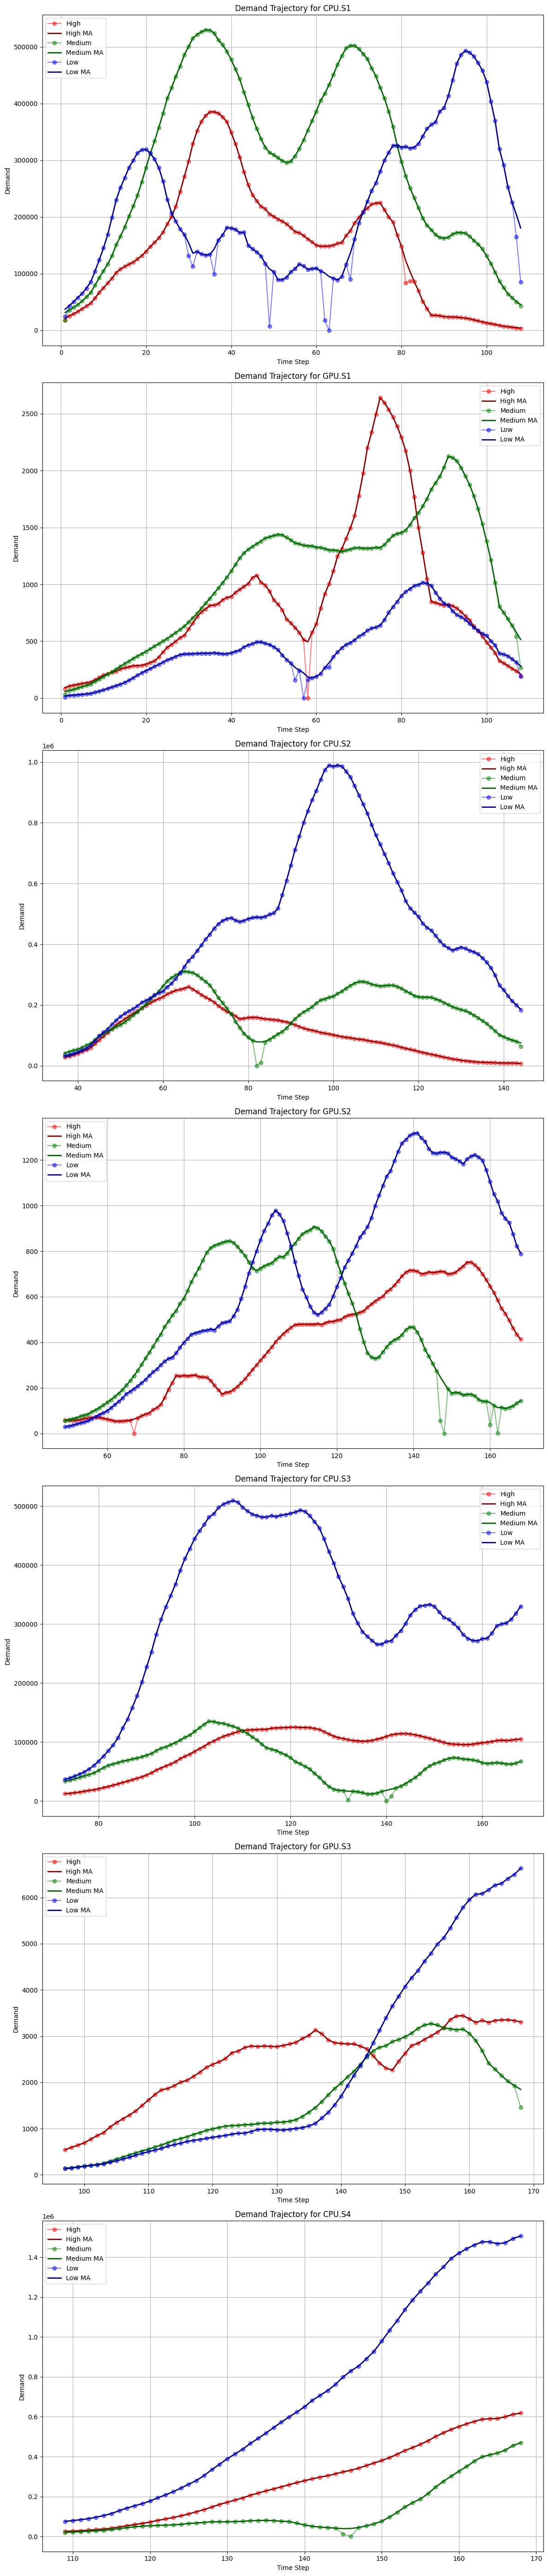

In [17]:
ma_demand_plot(new_demand, 12)

In [24]:
new_prices.to_csv('new_prices.csv')